In [37]:
import logging
logging.basicConfig(format='%(asctime)s : %(threadName)s : %(levelname)s : %(message)s', level=logging.INFO)
#import bamboolib as bam
import pandas as pd
import glob
import sqlite3
import spacy
import textacy
import explacy
from spacy.matcher import Matcher
from spacy.util import filter_spans
import numpy as np

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure, show
from bokeh.sampledata.stocks import AAPL
from bokeh.plotting import ColumnDataSource, figure, show, output_file, save
from bokeh.models import Band
from bokeh.models import HoverTool

from tqdm import tqdm
from collections import Counter

from spacy.tokenizer import _get_regex_pattern
import re
from operator import itemgetter
import collections
import math

In [38]:
import random
from functools import partial
import pandas as pd
from spacymoji import Emoji
import csv
import os



## where data are located

In [39]:

#a changer localement
media_filename='../medias/data/extracted_5G.csv'
tweet_path='../twitter/data5G/*'
fb_filename="../facebook/data/posts_5g.csv"


#smoothing_scale=7
#context_scale=182
#freq_threshold=100




## first Facebook data

In [40]:
fb= pd.read_csv(fb_filename)
fb['id']=fb.index
fb['title']=fb['title'].fillna('')
fb['description']=fb['description'].fillna('')
fb['caption']=fb['caption'].fillna('')

fb['message']=fb['message'].fillna('')

fb['text']=fb['title']+'\n'+fb['description']+'\n'+fb['caption']+'\n'+fb['message']

#fbcount

In [41]:
#fbcount

In [42]:
print (len(fb))
#fb=fb.dropna(subset=['text'])
fb['text']=fb['text'].fillna('')
fb['date'] = pd.to_datetime(fb["date"])
#fb2=fb.copy()
#fb2.index = fb2['date']

#fb2['count']=1


fb['date']=pd.to_datetime(fb['date'].dt.date)

fb.reset_index()
len(fb)

205311


205311

In [43]:
fb['cuisine']=fb.text.str.contains('cuisine|recette|sucre|pain|lingot|bonbon|safran')

In [44]:
fb=fb[~fb['cuisine']]
len(fb)

197629

In [45]:
#for h in list(fb[fb.cuisine==True].sample(n=10).text.values):
#    print ('*******\n\n\n',h)


In [168]:
#fb['prix']=fb.text.str.contains('prix|iphone|Xiaomi|Redmi|samsung|oppo|android|Sony|Apple')
#fb.prix.value_counts()

False    150045
True      47584
Name: prix, dtype: int64

In [163]:
fb[fb.date>"2022-01-01"][['text']].sample(10).values

array([['\n\n\nTéléphone Neuf Sceller Xiaomi Poco f3 5G Global version CE Prix: 7.250.000 fmg Fixe Tel: 0343992467 / 0326907916 ______________________ 🟩Double Sim 5G 🟩Ecran 6,7" FHD+ SuperAMOLED 120hz 🟩Octacore Snapdragon 870 🟩Ram 6go 🟩Stockage 128go 📷Caméra tout mode: 48Mpx Capteur Sony IMX 8Mpx Ultra grand angle 5Mpx Macro 📷Selfie 20 Mpx 🟩Empreinte 🟩Batterie 4250mah avec Fast charging 33w 🎮Gpu Adreno 650 (PUBG Max setting fluide be)'],
       ['\n\n\nL\'arrivée des gammes des séries Redmi Note 11 GLOBAL VERSION est proche 😁 🧐 Mais avant cela , expliquons un peu les modèles en vente pour ces nouveautés de 2022 📱 🔹 Xiaomi a sorti pour cette année, 4 variantes du Redmi Note 11 1️⃣ Premièrement, le Redmi Note 11 équipé du Qualcomm Snapdragon 680 4G , d\'un capteur principal de 50mpx 📷 , d\'un écran de 6.43" Amoled et un taux de rafraîchissement de 90Hz et une batterie de 5000mAh rechargeable sur 33W 2️⃣ Après, le Redmi Note 11s équipé du Mediatek Helio G96 4G donc plus de puissance que s

<AxesSubplot:xlabel='date'>

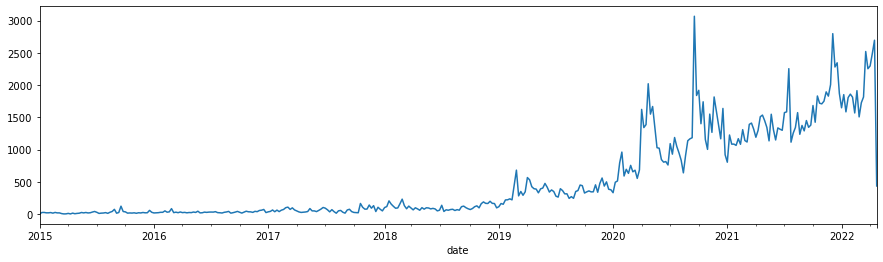

In [169]:
#plot the overall shape of the facebook posts
fbcount = fb.groupby(['date']).agg(id_count=('id', 'size')).reset_index()
fbcount.index=fbcount['date']#.resample
fbcount.resample("1w")['id_count'].sum().plot(figsize=(15,4))


In [171]:
#plot the overall shape of the facebook posts
#fbcount = fb[fb.prix==False].groupby(['date']).agg(id_count=('id', 'size')).reset_index()
#fbcount.index=fbcount['date']#.resample
#fbcount.resample("1w")['id_count'].sum().plot(figsize=(15,4))



## then mediacloud data

In [48]:
#media = pd.read_json('d:/Projects/Medialab/anses/BM_export_otmedia_docs_prod_v5_2018_2019_anses 2.json', lines=True)
media = pd.read_csv(media_filename)
media['title']=media['title'].fillna('')
media['raw_content']=media['raw_content'].fillna('')


media['text']=media['title']+  '\n' + media['raw_content']
#media['text']=media['text'].fillna('')


media['id']=media['stories_id']
#media['text']=media['title'] + ". " + media['document']
#media

In [49]:
#media.id.nunique(),len(media)
media.drop_duplicates(subset=['stories_id'],inplace=True)
media.id.nunique(),len(media)

(19328, 19328)

In [50]:

#media=media[media["publish_date"]!='undateable']
#mediaselect['date'] = pd.to_datetime(mediaselect['docTime']).dt.date

media['date'] = pd.to_datetime(pd.to_datetime(media["publish_date"]).dt.date)
media = media.reset_index()
media


,level_0,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,...,description,raw_content,comments,author,categories,tags,date,sitename,text,id
0,0,322425839,2015-02-27 07:00:05,Samsung en reconquête au congrès de Barcelone,http://rss.feedsportal.com/c/32394/f/668870/s/...,fr,False,NaN,39909,laprovence,...,NaN,,NaN,NaN,NaN,NaN,2015-02-27,NaN,Samsung en reconquête au congrès de Barcelone\n,322425839
1,1,367088338,2015-08-05 06:55:06,Smartphones: Xiaomi et Huawei croquent Apple e...,http://flux.20minutes.fr/c/32497/f/479493/s/48...,fr,False,NaN,62407,20minutes.fr,...,NaN,,NaN,NaN,NaN,NaN,2015-08-05,NaN,Smartphones: Xiaomi et Huawei croquent Apple e...,367088338
2,2,342149219,2015-05-06 08:13:00,Marché unique du numérique: Bruxelles présente...,http://www.lavoixdunord.fr/economie/marche-uni...,fr,False,NaN,39802,lavoixdunord,...,NaN,,NaN,NaN,NaN,NaN,2015-05-06,NaN,Marché unique du numérique: Bruxelles présente...,342149219
3,3,345521863,2015-05-18 13:26:18,"Transports, santé, sécurité… l'industrie du fu...",http://www.capital.fr/a-la-une/politique-econo...,fr,False,NaN,39604,capital-FR,...,NaN,,NaN,NaN,NaN,NaN,2015-05-18,NaN,"Transports, santé, sécurité… l'industrie du fu...",345521863
4,4,335763144,2015-04-14 14:37:06,"Nokia et Alcatel-Lucent, un rapprochement indu...",http://www.corsematin.com/article/france/nokia...,fr,False,NaN,39309,corsematin,...,NaN,,NaN,NaN,NaN,NaN,2015-04-14,NaN,"Nokia et Alcatel-Lucent, un rapprochement indu...",335763144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19323,19323,1889036757,2021-02-25 03:33:31,Taxe IFER pour les opérateurs mobiles : deux n...,https://www.nextinpact.com/article/46227/taxe-...,fr,False,NaN,258426,nextinpact.com,...,"Bouygues Telecom, Free Mobile, Orange et SFR d...","Bouygues Telecom, Free Mobile, Orange et SFR d...",NaN,NaN,NaN,Finances,2021-02-25,Next INpact,Taxe IFER pour les opérateurs mobiles : deux n...,1889036757
19324,19324,1818529052,2021-01-08 09:00:37,Xavier Niel en Free style : Freebox Delta et P...,https://www.nextinpact.com/article/45318/xavie...,fr,False,NaN,258426,nextinpact.com,...,Alors que l'année commence et que Free Mobile ...,Alors que l'année commence et que Free Mobile ...,NaN,Sébastien Gavois,NaN,FAI,2021-01-08,Next INpact,Xavier Niel en Free style : Freebox Delta et P...,1818529052
19325,19325,1889099177,2021-02-10 04:15:42,ANFR : « près de 55 500 sites 4G et 20 000 sit...,https://www.nextinpact.com/article/45984/anfr-...,fr,False,NaN,258426,nextinpact.com,...,"Comme chaque début de mois, l’Agence nationale...","Comme chaque début de mois, l’Agence nationale...",NaN,NaN,NaN,Téléphonie,2021-02-10,Next INpact,ANFR : « près de 55 500 sites 4G et 20 000 sit...,1889099177
19326,19326,1845852923,2021-02-08 03:57:59,"#LeBrief : loi 5G « anti-Huawei » adoubée, eff...",https://www.nextinpact.com/lebrief/728,fr,False,NaN,258426,nextinpact.com,...,Retrouvez l'actualité en bref de l'informatiqu...,Aussi bien sur les réseaux sociaux que dans la...,NaN,NaN,NaN,Le Brief|Actualités|Numérique|Next INpact|Info...,2021-02-08,INpact MediaGroup,"#LeBrief : loi 5G « anti-Huawei » adoubée, eff...",1845852923


In [127]:
media['cuisine']=media.text.str.contains('cuisine|recette|sucre|pain|lingot|bonbon|safran')
#media['5g']=media.text.str.contains('5g')
#media['no5G']=~media.text.str.contains('5G')
#media['out']=media['no5G']

In [129]:
media=media[media['cuisine']==False]

In [130]:
print (len(media))
media=media.dropna(subset=['text'])

#media.reset_index()
print(len(media))

18331
18331


In [131]:
media=media[media['date']<'2021-09-01']
len(media)

18331

In [132]:
media.sample(5).title.values

array(['« Crise du Covid » ou comment l’OMS a agi comme un instrument de manipulation mondiale — Les Maîtres du Monde — Sott.net',
       "L'UE veut doubler sa part dans la production de semi-conducteurs d'ici 2030",
       'Coronavirus: une organisation minutieuse du massacre ?',
       'Des failles de sécurité inquiétantes sur les réseaux 4G et 5G @TahaaNumerique',
       'La 5G débarque en France, y a-t-il un risque sanitaire ?'],
      dtype=object)

<AxesSubplot:xlabel='date'>

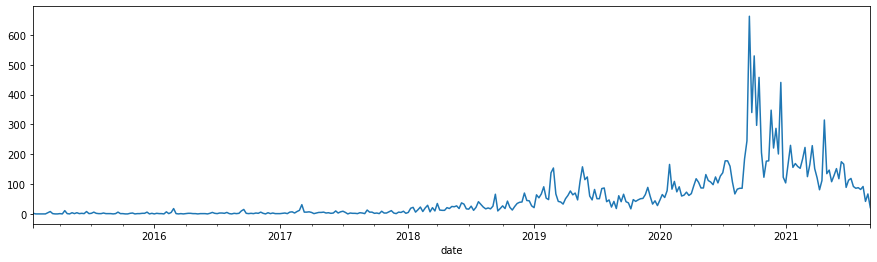

In [133]:
#plot the overall shape of the media articles in time
mediacount = media.groupby(['date']).agg(id_count=('id', 'size')).reset_index()
mediacount.index=mediacount['date']#.resample
mediacount.resample("1w")['id_count'].sum().plot(figsize=(15,4))



## finally Twitter data

In [134]:
#paths = glob.glob('d:/Projects/Medialab/Anses/tweetstotal/*')
paths=glob.glob(tweet_path)
paths

['../twitter/data5G/5G.csv',
 '../twitter/data5G/5G_until_dec28_2020.csv',
 '../twitter/data5G/5G_until_fev24_2020.csv']

In [135]:
tweet_path

'../twitter/data5G/*'

In [136]:
dico_id={'id': 'string',
 'to_userid': 'string',
 'to_tweetid': 'string',
 'user_id': 'string',
 'retweeted_id': 'string',
 'retweeted_user_id': 'string',
 'quoted_id': 'string',
 'quoted_user_id': 'string',
 'mentioned_ids': 'string'}
tweets=pd.DataFrame()
for p in [f for f in paths if not '.zip' in f]:
    print ("processing ",p)
    df=pd.read_csv(p,dtype=dico_id)
    tweets=tweets.append(df, ignore_index=True)
tweets=tweets.drop_duplicates()
tweets['date'] = pd.to_datetime(pd.to_datetime(tweets['local_time']).dt.date)
#tweets

processing  ../twitter/data5G/5G.csv


/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_6137/1440921129.py:13: DtypeWarning: Columns (56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(p,dtype=dico_id)
/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_6137/1440921129.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tweets=tweets.append(df, ignore_index=True)


processing  ../twitter/data5G/5G_until_dec28_2020.csv


/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_6137/1440921129.py:13: DtypeWarning: Columns (56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(p,dtype=dico_id)
/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_6137/1440921129.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tweets=tweets.append(df, ignore_index=True)


processing  ../twitter/data5G/5G_until_fev24_2020.csv


/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_6137/1440921129.py:13: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(p,dtype=dico_id)
/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_6137/1440921129.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tweets=tweets.append(df, ignore_index=True)


In [137]:
print (len(tweets))
tweets=tweets.dropna(subset=['text'])
tweets = tweets.reset_index()

#tweets = tweets.loc[~(tweets['text'].str.contains('N.H.L.', case=False, regex=False, na=False))]
#print (len(tweets))


808127


In [138]:
tweets.user_screen_name.value_counts()

Kellerarduino      27112
Digitaltrans4mF    10979
marco_5g            3751
YosAmRaN2           2240
EricFitteDuval      2214
                   ...  
pierdziryjek           1
ZorteK                 1
HUNGRYLIFESTARF        1
mikasimplement         1
p_moraisribz           1
Name: user_screen_name, Length: 227270, dtype: int64

In [139]:
tweets_keller=tweets[tweets['user_screen_name']=='Kellerarduino']

In [140]:
tweets_keller['5G']=tweets_keller.text.str.contains('5G')

/var/folders/bx/gl47n30d0zbbbqzp9zh3kcrr0000gn/T/ipykernel_6137/3867370031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_keller['5G']=tweets_keller.text.str.contains('5G')


In [141]:
tweets_keller[['text','5G']].values

array([['fan K1 on !!! Temp. inside 13°c Hum. inside 69% H2O 9g/m^3 Temp. outside 2°c Hum. outside 75% H2O 5g/m^3',
        False],
       ['fan K1 on !!! Temp. inside 13°c Hum. inside 69% H2O 9g/m^3 Temp. outside 2°c Hum. outside 76% H2O 5g/m^3',
        False],
       ['fan K1 on !!! Temp. inside 13°c Hum. inside 69% H2O 9g/m^3 Temp. outside 2°c Hum. outside 77% H2O 5g/m^3',
        False],
       ...,
       ['fan K1 on !!! Temp. inside 19°c Hum. inside 57% H2O 10g/m^3 Temp. outside 13°c Hum. outside 43% H2O 5g/m^3',
        False],
       ['fan K1 on !!! Temp. inside 19°c Hum. inside 57% H2O 10g/m^3 Temp. outside 14°c Hum. outside 43% H2O 5g/m^3',
        False],
       ['fan K1 on !!! Temp. inside 19°c Hum. inside 57% H2O 10g/m^3 Temp. outside 13°c Hum. outside 44% H2O 5g/m^3',
        False]], dtype=object)

In [142]:
len(tweets)
tweets=tweets[tweets.text.str.contains('5G|5g')]
len(tweets)

801512

In [143]:
len(tweets)
tweets=tweets[tweets.text.str.contains(' 5G| 5g|5G |5G.|5g |5g.|5g,|5G,|#5G|#5g|•5G|•5g|,5G|,5g|5G\n|5g\n|/5G|/5g')]
tweets=tweets[~tweets.text.str.contains('5G/|5g/')]
len(tweets)

756190

In [144]:
#for x in tweets.sample(n=20).text.values:
#    print('****\n',x)

In [145]:
tweets=tweets.drop_duplicates(subset=['user_screen_name','text'])
len(tweets)

746403

In [146]:
#tweets[tweets['user_screen_name']=='YosAmRaN2'].sample(n=2).text.values

In [147]:
#import csv
#tweets.to_csv('../twitter/twitter_nonnum.csv',quoting=csv.QUOTE_NONNUMERIC)#,line_terminator='\n',index=False)
#dfa=pd.read_csv('../twitter/twitter_nonnum.csv',dtype=dico_id)
#len(dfa)


<AxesSubplot:xlabel='date'>

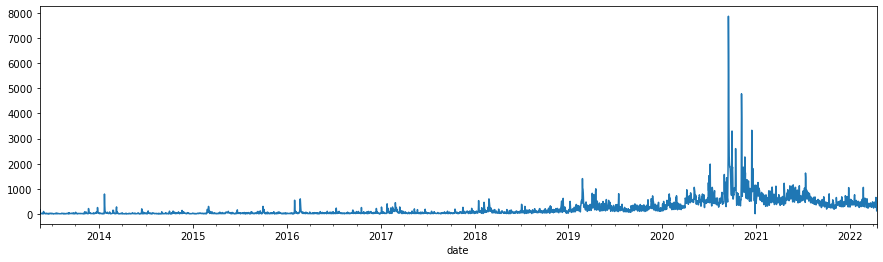

In [148]:
#plot the overall shape of the tweets over time
tweetscount = tweets.groupby(['date']).agg(id_count=('id', 'size')).reset_index()
tweetscount.index=tweetscount['date']#.resample
tweetscount.resample("1d")['id_count'].sum().plot(figsize=(15,4))




## we merge the three dataframes in one

In [149]:
tweets['source']=tweets['user_name']
fb['source']=fb['account_name']
media['source']=media['media_name']
tweets['origin']='twitter'
media['origin']='media'
fb['origin']='facebook'
dfall=pd.concat([tweets[['id','date','text','source','origin']],media[['id','date','text','source','origin']],fb[['id','date','text','source','origin']]])

In [150]:
dfall.to_csv('../all3/fb_tw_med_data_5G.csv.gz',quoting=csv.QUOTE_NONNUMERIC)#,line_terminator='\n',index=False)

len(dfall)

962363

# Alternatively, one can read all the agregated data at once: 

In [151]:
dfall=pd.read_csv('../all3/fb_tw_med_data_5G.csv.gz')#,line_terminator='\n',index=False)

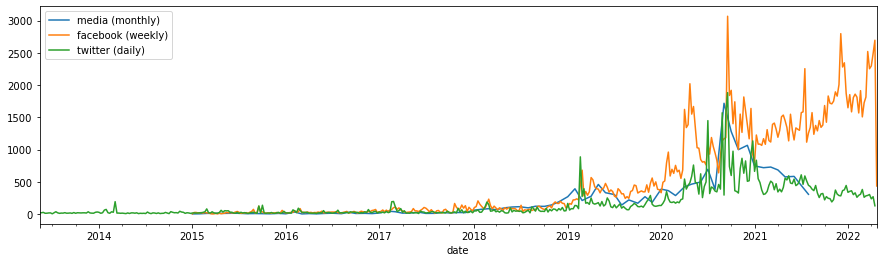

In [152]:
#plot the overall shape of the tweets over time
from matplotlib import pyplot as plt
dfall['date']=pd.to_datetime(dfall['date'])
dfallcount = dfall.groupby(['origin','date']).agg(id_count=('id', 'size')).reset_index()
dfallcount.index=dfallcount['date']#.resample
dfallcount=dfallcount[dfallcount['date']>'2012']
dfallcount[dfallcount['origin']=='media'].resample("1m")['id_count'].sum().plot(figsize=(15,4), label='media (monthly)')
dfallcount[dfallcount['origin']=='facebook' ].resample("1w")['id_count'].sum().plot(figsize=(15,4), label='facebook (weekly)')
dfallcount[dfallcount['origin']=='twitter'].resample("1d")['id_count'].sum().plot(figsize=(15,4), label='twitter (daily)')
plt.legend()

plt.savefig('../images/ts_5G.pdf')